In [55]:
import pypsa
import pandas as pd

In [57]:
# =====================
# Datenaufbereitung: Konvertiere Excel zu CSV
# =====================

import zipfile
import xml.etree.ElementTree as ET

def read_simple_xlsx(filename):
    """Liest eine einfache XLSX-Datei ohne openpyxl"""
    with zipfile.ZipFile(filename, 'r') as z:
        # Lade die Shared Strings (falls vorhanden)
        try:
            shared_strings_xml = z.read('xl/sharedStrings.xml')
            strings_root = ET.fromstring(shared_strings_xml)
            shared_strings = [elem.text for elem in strings_root.findall('.//{http://schemas.openxmlformats.org/spreadsheetml/2006/main}t')]
        except:
            shared_strings = []
        
        # Lade das erste Sheet
        sheet_xml = z.read('xl/worksheets/sheet1.xml')
        root = ET.fromstring(sheet_xml)
        
        # Extrahiere Daten
        data = []
        namespace = {'ns': 'http://schemas.openxmlformats.org/spreadsheetml/2006/main'}
        
        for row in root.findall('.//ns:row', namespace):
            row_data = []
            for cell in row.findall('.//ns:c', namespace):
                cell_type = cell.get('t')
                value_elem = cell.find('ns:v', namespace)
                
                if value_elem is not None:
                    if cell_type == 's':  # String aus shared strings
                        idx = int(value_elem.text)
                        row_data.append(shared_strings[idx] if idx < len(shared_strings) else '')
                    else:  # Numerischer Wert
                        try:
                            row_data.append(float(value_elem.text))
                        except:
                            row_data.append(value_elem.text)
                else:
                    row_data.append(None)
            
            if row_data:
                data.append(row_data)
        
        return data

# Konvertiere die Excel-Datei nur beim ersten Mal oder wenn CSV nicht existiert
import os
if not os.path.exists('ninja_pv_51.1601_13.csv') or os.path.getmtime('ninja_pv_51.1601_13.7660.xlsx') > os.path.getmtime('ninja_pv_51.1601_13.csv'):
    print("Konvertiere ninja_pv Excel-Datei...")
    data = read_simple_xlsx('ninja_pv_51.1601_13.7660.xlsx')
    
    # Erste Zeile = Header, Rest = Daten
    headers = data[0] if data else []
    values = data[1:] if len(data) > 1 else []
    
    # Erstelle DataFrame und normalisiere
    df = pd.DataFrame(values, columns=headers)
    
    # Konvertiere zu numerischen Werten (falls Strings vorhanden)
    df['electricity'] = pd.to_numeric(df['electricity'], errors='coerce').fillna(0)
    
    # Normalisiere Werte auf 0-1 (PyPSA erwartet normalisierte Werte für p_max_pu)
    if df['electricity'].max() > 1.1:
        df['electricity'] = df['electricity'] / df['electricity'].max()
    
    # Speichere als CSV
    df.to_csv('ninja_pv_51.1601_13.csv', index=False)
    print(f"✓ Konvertiert: {df.shape[0]} Stunden, Volllaststunden: {df['electricity'].sum():.0f} h/Jahr")
else:
    print("✓ ninja_pv_51.1601_13.csv bereits vorhanden")

Konvertiere ninja_pv Excel-Datei...
✓ Konvertiert: 8760 Stunden, Volllaststunden: 1309 h/Jahr


In [58]:
# =====================
# Grundparameter Standort
# =====================

roof_area = 5500                 # Gebäudefläche [m²]
number_transporter = 78          # Anzahl E-Fahrzeuge
capacitiy_battery_transporter = 40  # Batteriekapazität je Fahrzeug [kWh]
inhouse_pv = 0.35                # Max. PV-Leistung auf dem Dach [MW]

# =====================
# Wärmebedarfe (vereinfachte Annahmen)
# =====================

DHW_load_hourly = roof_area * 0.008 / 8760      # Trinkwarmwasser [MW]
Thermal_load_hourly = roof_area * 0.05 / 8760   # Raumheizung [MW]

# =====================
# Zeitprofile
# =====================

# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
renewable_profile_solar = (pd.read_csv("ninja_pv_51.1601_13.csv", usecols=["electricity"])
    ["electricity"].astype(float))  # Stündliches, normiertes PV-Erzeugungsprofil

custom_load_profile_MW = (pd.read_csv("jahreslastgang_dhl (1).csv", usecols=["load_kWh"])
    ["load_kWh"].astype(float) / 1000) # Standortlastgang, von kWh/h in MW umgerechnet

# PyPSA-Netz
network = pypsa.Network()
network.set_snapshots(range(8760))  # Stündliche Auflösung übers Jahr

# Busse
network.add("Bus", name="electricity")
network.add("Bus", name="heat_0")   # Trinkwarmwasser
network.add("Bus", name="heat_1")   # Raumheizung


# Erzeugung & Netz
network.add("Generator", "PV", bus="electricity",
    p_nom=inhouse_pv,
    p_max_pu=renewable_profile_solar,
    marginal_cost=5)

network.add("Generator", "Grid", bus="electricity",
    p_nom=1.3,           # Netzanschlussleistung [MW]
    marginal_cost=300)


# Lasten (Anteile des Gesamtprofils)
network.add("Load", "Electric_Load",bus="electricity", p_set=custom_load_profile_MW * 0.15)
network.add("Load", "Fleet_Load",bus="electricity", p_set=custom_load_profile_MW * 0.7)
network.add("Load", "DHW_Load",bus="heat_0", p_set=custom_load_profile_MW * 0.05)
network.add("Load", "Thermal_Load",bus="heat_1", p_set=custom_load_profile_MW * 0.1)


# Wärmepumpen
network.add("Link", "Heat_Pump_0", bus0="electricity", bus1="heat_0",
            efficiency=3, p_nom=0.045) # roof_area* 8 [W/qm] -Recherche

network.add("Link", "Heat_Pump_1", bus0="electricity", bus1="heat_1",
            efficiency=3, p_nom=0.22) # roof_area* 40 [W/qm]  -Recherche


# Wärmespeicher
network.add("Store", "DHW_Storage",
            bus="heat_0", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)

network.add("Store", "Thermal_Storage",
            bus="heat_1", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)


# Batteriespeicher (Größe wird optimiert)
# Für zeitliche Verschiebung der E-Fahrzeug-Ladung (nachts) und PV-Nutzung (tags)
network.add("Store", "Battery_Storage",
            bus="electricity", 
            e_nom_extendable=True,      # Speichergröße wird optimiert
            e_cyclic=True,               # Zyklisch über das Jahr
            standing_loss=0.0001,        # 0.01% Selbstentladung pro Stunde (typisch für Li-Ion)
            capital_cost=180,            # Investitionskosten: ca. 180 €/kWh
            efficiency_store=0.95,       # Lade-Effizienz 95%
            efficiency_dispatch=0.95)    # Entlade-Effizienz 95%

In [59]:
# Optimierung mit verfügbarem Solver (HiGHS ist in PyPSA enthalten)
network.optimize(solver_name='highs')

Index(['electricity', 'heat_0', 'heat_1'], dtype='object', name='name')
Index(['Heat_Pump_0', 'Heat_Pump_1'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery_Storage'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 255.82it/s]
INFO:linopy.io: Writing time: 0.25s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-yyxffwge has 175203 rows; 87603 cols; 306603 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 3e+00]
  Cost    [5e+00, 3e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 1e+00]
Presolving model
43800 rows, 65431 cols, 135510 nonzeros  0s
35040 rows, 56671 cols, 117990 nonzeros  0s
Dependent equations search running on 26280 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
35040 rows, 56671 cols, 117990 nonzeros  0s
Presolve reductions: rows 35040(-140163); columns 56671(-30932); nonzeros 117990(-188613) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.3343164423e-05 Pr: 26280(1034.96) 0s
      33968     1.4222131263e+05 Pr: 7869(172539) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87603 primals, 175203 duals
Objective: 1.46e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      47638     1.4588567081e+05 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-yyxffwge
Model status        : Optimal
Simplex   iterations: 47638
Objective value     :  1.4588567072e+05
P-D objective error :  7.3514586545e-14
HiGHS run time      :          5.80


('ok', 'optimal')

In [60]:
# Jährlicher PV-Ertrag [MWh]
pv_generation = network.generators_t.p["PV"].sum()

# Gesamtstromverbrauch des Standorts [MWh]
total_load = network.loads_t.p.sum(axis=1).sum()

# Jährlicher Strombezug aus dem öffentlichen Netz [MWh]
grid_import = network.generators_t.p["Grid"].clip(lower=0).sum()

# Autarkiegrad [-]: Anteil des Stromverbrauchs, der ohne Netzbezug gedeckt wird
autarky = 1 - grid_import / total_load

# Elektrische Energieaufnahme der Wärmepumpe für Raumheizung [MWh]
el_heat = network.links_t.p0["Heat_Pump_1"].abs().sum()

# Erzeugte thermische Energie für Raumheizung [MWh]
th_heat = network.links_t.p1["Heat_Pump_1"].sum()

# Jahresarbeitszahl der Heizungs-Wärmepumpe [-]
JAZ_heat = th_heat / el_heat

# Elektrische Energieaufnahme der Wärmepumpe für Trinkwarmwasser [MWh]
el_dhw = network.links_t.p0["Heat_Pump_0"].abs().sum()

# Erzeugte thermische Energie für Trinkwarmwasser [MWh]
th_dhw = network.links_t.p1["Heat_Pump_0"].sum()

# Jahresarbeitszahl der Trinkwarmwasser-Wärmepumpe [-]
JAZ_dhw = th_dhw / el_dhw

# Jährlicher Energiebedarf der E-Fahrzeugflotte [MWh]
fleet_energy = network.loads_t.p["Fleet_Load"].sum()

# =====================
# Batteriespeicher-Kennzahlen
# =====================

# Optimierte Batteriespeichergröße [MWh]
battery_capacity = network.stores.loc["Battery_Storage", "e_nom_opt"]

# Gesamte ein- und ausgespeicherte Energie [MWh]
battery_charge = network.stores_t.p["Battery_Storage"].clip(lower=0).sum()  # Laden
battery_discharge = -network.stores_t.p["Battery_Storage"].clip(upper=0).sum()  # Entladen

# Zyklenzahl (Vollzyklen pro Jahr)
battery_cycles = battery_discharge / battery_capacity if battery_capacity > 0 else 0

# Eigenverbrauchsquote PV (Anteil der PV-Erzeugung, der direkt genutzt oder gespeichert wird)
pv_direct_use = pv_generation - (pv_generation - total_load + grid_import)
pv_self_consumption = pv_direct_use / pv_generation if pv_generation > 0 else 0


In [61]:
print("=" * 50)
print("ERGEBNISSE DER OPTIMIERUNG")
print("=" * 50)
print(f"\n🔋 PV-Ertrag: {pv_generation:.1f} MWh/a")
print(f"⚡ Autarkiegrad: {autarky*100:.1f} %")
print(f"📊 PV-Eigenverbrauch: {pv_self_consumption*100:.1f} %")
print(f"\n🔥 JAZ Heizung: {JAZ_heat:.2f}")
print(f"💧 JAZ Warmwasser: {JAZ_dhw:.2f}")
print(f"\n🚗 E-Flotte Energiebedarf: {fleet_energy:.1f} MWh/a")
print(f"\n🔋 Batteriespeicher:")
print(f"   Optimierte Größe: {battery_capacity:.2f} MWh ({battery_capacity*1000:.0f} kWh)")
print(f"   Lade-Energie: {battery_charge:.1f} MWh/a")
print(f"   Entlade-Energie: {battery_discharge:.1f} MWh/a")
print(f"   Vollzyklen/Jahr: {battery_cycles:.1f}")
print(f"\n💾 Wärmespeicher:")
print(f"   Warmwasser: {network.stores.loc['DHW_Storage', 'e_nom_opt']:.2f} MWh ({network.stores.loc['DHW_Storage', 'e_nom_opt']*1000:.0f} kWh)")
print(f"   Heizung: {network.stores.loc['Thermal_Storage', 'e_nom_opt']:.2f} MWh ({network.stores.loc['Thermal_Storage', 'e_nom_opt']*1000:.0f} kWh)")
print("=" * 50)


ERGEBNISSE DER OPTIMIERUNG

🔋 PV-Ertrag: 458.1 MWh/a
⚡ Autarkiegrad: 54.1 %
📊 PV-Eigenverbrauch: 122.3 %

🔥 JAZ Heizung: -3.00
💧 JAZ Warmwasser: -3.00

🚗 E-Flotte Energiebedarf: 724.5 MWh/a

🔋 Batteriespeicher:
   Optimierte Größe: 6.83 MWh (6830 kWh)
   Lade-Energie: 193.9 MWh/a
   Entlade-Energie: 194.8 MWh/a
   Vollzyklen/Jahr: 28.5

💾 Wärmespeicher:
   Warmwasser: 1.15 MWh (1154 kWh)
   Heizung: 2.36 MWh (2358 kWh)


# 📊 Auswertung & Visualisierung

---

## 🎯 HAUPTERGEBNISSE: Vergleich mit/ohne Batteriespeicher

Dieser Vergleich zeigt die **wichtigsten Kennzahlen** des optimierten Energiesystems mit und ohne Batteriespeicher. Die Analyse verdeutlicht den signifikanten Einfluss des Batteriespeichers auf:
- **Autarkiegrad** (Unabhängigkeit vom Stromnetz)
- **Netzbezug** (eingekaufte Energie)
- **Systemkosten** (Gesamtkosten inkl. aller Komponenten)
- **Speichergrößen** (optimierte Kapazitäten)

Index(['electricity', 'heat_0', 'heat_1'], dtype='object', name='name')
Index(['Heat_Pump_0', 'Heat_Pump_1'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage'], dtype='object', name='name')



VERGLEICHSRECHNUNG: MIT vs. OHNE BATTERIESPEICHER

⏳ Optimiere System OHNE Batteriespeicher...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 330.86it/s]
INFO:linopy.io: Writing time: 0.21s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-0i_za8c9 has 148922 rows; 70082 cols; 245282 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 3e+00]
  Cost    [5e+00, 3e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 1e+00]
Presolving model
19438 rows, 41065 cols, 60229 nonzeros  0s
Dependent equations search running on 19435 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
19435 rows, 38870 cols, 60220 nonzeros  0s
Presolve reductions: rows 19435(-129487); columns 38870(-31212); nonzeros 60220(-185062) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.8830722588e+05 Pr: 19435(300.866) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70082 primals, 148922 duals
Objective: 1.92e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      26316     1.9231242107e+05 Pr: 0(0); Du: 0(5.94706e-12) 2s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-0i_za8c9
Model status        : Optimal
Simplex   iterations: 26316
Objective value     :  1.9231242098e+05
P-D objective error :  2.4062392787e-14
HiGHS run time      :          1.72

KENNZAHL                        OHNE Batterie   MIT Batterie
PV-Ertrag [MWh/a]                       306.0          458.1
Netzbezug [MWh/a]                       635.9          474.6
Autarkiegrad [%]                         38.6           54.1
Systemkosten [€/a]                     192312         145886
------------------------------------------------------------
Batteriegröße [kWh]                         0           6830
Warmwasserspeicher [kWh]                 3550           1154
Heizungsspeicher [kWh]                   7069           2358

📊 VERBESSERUNGEN DURCH BATTERIESPEICHER:
  ⚡ Autarkiegrad: +15.6 Prozentpunkte
  📉 N

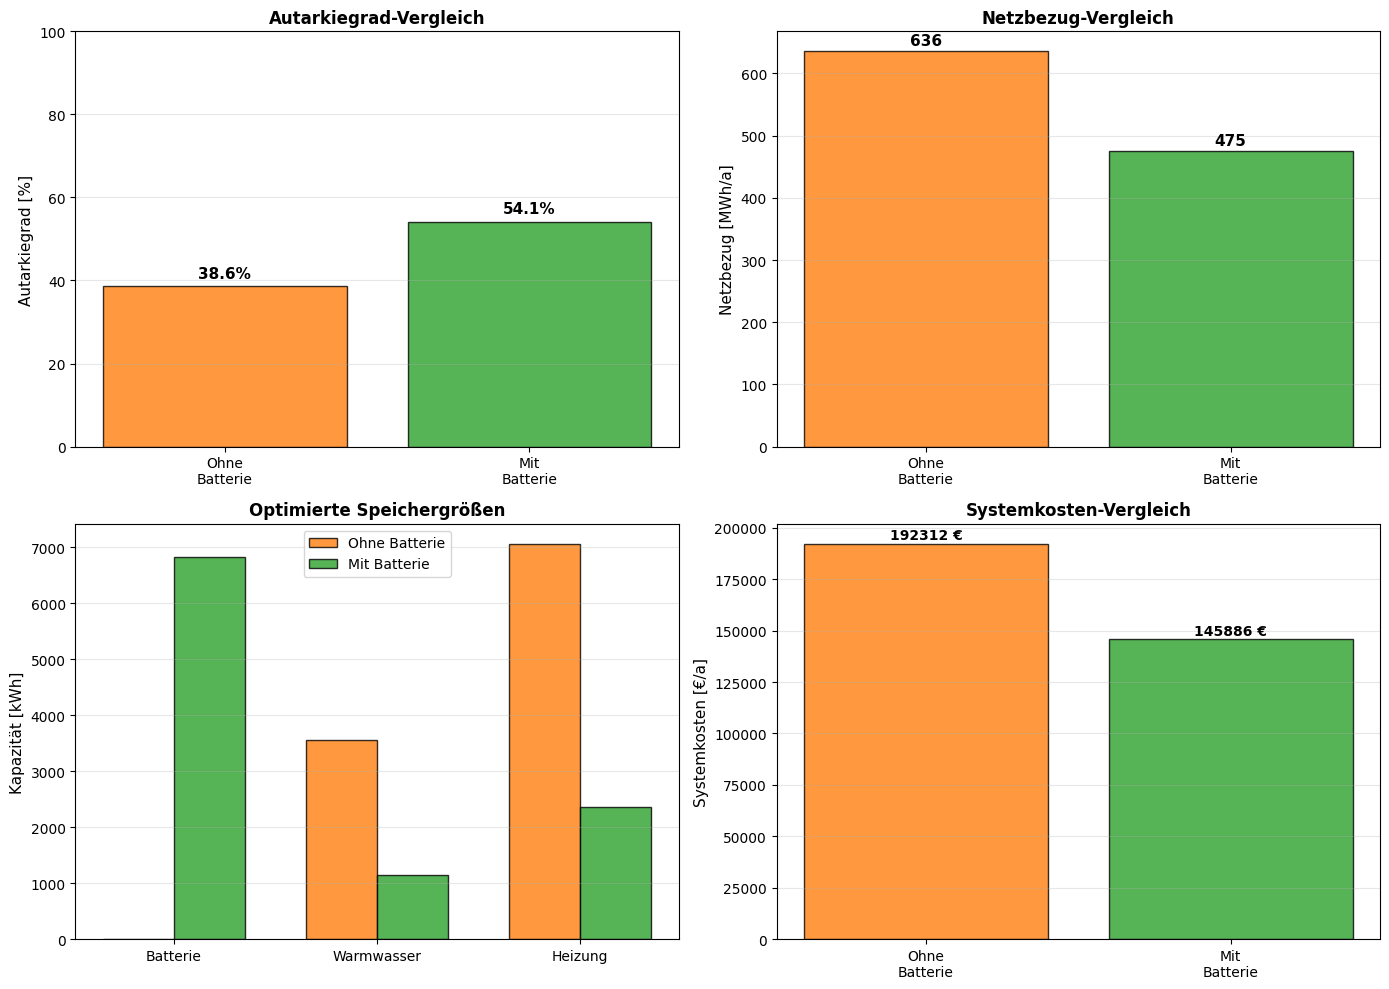


✅ Vergleich abgeschlossen!


In [62]:
# =====================
# VERGLEICH: Mit vs. Ohne Batteriespeicher
# =====================

import numpy as np

print("\n" + "="*60)
print("VERGLEICHSRECHNUNG: MIT vs. OHNE BATTERIESPEICHER")
print("="*60)

# Erstelle Netzwerk OHNE Batteriespeicher
network_no_battery = pypsa.Network()
network_no_battery.set_snapshots(range(8760))

# Busse
network_no_battery.add("Bus", name="electricity")
network_no_battery.add("Bus", name="heat_0")
network_no_battery.add("Bus", name="heat_1")

# Erzeugung & Netz
network_no_battery.add("Generator", "PV", bus="electricity",
    p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=5)
network_no_battery.add("Generator", "Grid", bus="electricity",
    p_nom=1.3, marginal_cost=300)

# Lasten
network_no_battery.add("Load", "Electric_Load", bus="electricity", p_set=custom_load_profile_MW * 0.15)
network_no_battery.add("Load", "Fleet_Load", bus="electricity", p_set=custom_load_profile_MW * 0.7)
network_no_battery.add("Load", "DHW_Load", bus="heat_0", p_set=custom_load_profile_MW * 0.05)
network_no_battery.add("Load", "Thermal_Load", bus="heat_1", p_set=custom_load_profile_MW * 0.1)

# Wärmepumpen
network_no_battery.add("Link", "Heat_Pump_0", bus0="electricity", bus1="heat_0",
    efficiency=3, p_nom=0.045)
network_no_battery.add("Link", "Heat_Pump_1", bus0="electricity", bus1="heat_1",
    efficiency=3, p_nom=0.22)

# Wärmespeicher
network_no_battery.add("Store", "DHW_Storage", bus="heat_0", 
    e_nom_extendable=True, e_cyclic=True, standing_loss=0.005)
network_no_battery.add("Store", "Thermal_Storage", bus="heat_1", 
    e_nom_extendable=True, e_cyclic=True, standing_loss=0.005)

# Optimierung OHNE Batteriespeicher
print("\n⏳ Optimiere System OHNE Batteriespeicher...")
network_no_battery.optimize(solver_name='highs')

# Berechne Kennzahlen OHNE Batterie
pv_gen_no_bat = network_no_battery.generators_t.p["PV"].sum()
grid_imp_no_bat = network_no_battery.generators_t.p["Grid"].clip(lower=0).sum()
total_load_no_bat = network_no_battery.loads_t.p.sum(axis=1).sum()
autarky_no_bat = 1 - grid_imp_no_bat / total_load_no_bat
costs_no_bat = network_no_battery.objective

# Kennzahlen MIT Batterie (bereits berechnet)
pv_gen_bat = pv_generation
grid_imp_bat = grid_import
autarky_bat = autarky
costs_bat = network.objective

# Vergleichstabelle
print("\n" + "="*60)
print(f"{'KENNZAHL':<30} {'OHNE Batterie':>14} {'MIT Batterie':>14}")
print("="*60)
print(f"{'PV-Ertrag [MWh/a]':<30} {pv_gen_no_bat:>14.1f} {pv_gen_bat:>14.1f}")
print(f"{'Netzbezug [MWh/a]':<30} {grid_imp_no_bat:>14.1f} {grid_imp_bat:>14.1f}")
print(f"{'Autarkiegrad [%]':<30} {autarky_no_bat*100:>14.1f} {autarky_bat*100:>14.1f}")
print(f"{'Systemkosten [€/a]':<30} {costs_no_bat:>14.0f} {costs_bat:>14.0f}")
print("-"*60)
print(f"{'Batteriegröße [kWh]':<30} {0:>14.0f} {battery_capacity*1000:>14.0f}")
print(f"{'Warmwasserspeicher [kWh]':<30} {network_no_battery.stores.loc['DHW_Storage', 'e_nom_opt']*1000:>14.0f} {network.stores.loc['DHW_Storage', 'e_nom_opt']*1000:>14.0f}")
print(f"{'Heizungsspeicher [kWh]':<30} {network_no_battery.stores.loc['Thermal_Storage', 'e_nom_opt']*1000:>14.0f} {network.stores.loc['Thermal_Storage', 'e_nom_opt']*1000:>14.0f}")
print("="*60)

# Verbesserungen durch Batterie
print("\n📊 VERBESSERUNGEN DURCH BATTERIESPEICHER:")
print(f"  ⚡ Autarkiegrad: +{(autarky_bat - autarky_no_bat)*100:.1f} Prozentpunkte")
print(f"  📉 Netzbezug: -{(grid_imp_no_bat - grid_imp_bat):.1f} MWh/a ({(1-grid_imp_bat/grid_imp_no_bat)*100:.1f}% weniger)")
print(f"  💰 Kostenersparnis: {costs_no_bat - costs_bat:.0f} €/a")
print(f"  🔋 Batteriezyklen: {battery_cycles:.1f} Vollzyklen/Jahr")

# Visualisierung
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Autarkiegrad Vergleich
ax1 = axes[0, 0]
categories = ['Ohne\nBatterie', 'Mit\nBatterie']
autarky_values = [autarky_no_bat*100, autarky_bat*100]
colors = ['#ff7f0e', '#2ca02c']
bars = ax1.bar(categories, autarky_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Autarkiegrad [%]', fontsize=11)
ax1.set_title('Autarkiegrad-Vergleich', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, autarky_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold')

# 2. Netzbezug Vergleich
ax2 = axes[0, 1]
grid_values = [grid_imp_no_bat, grid_imp_bat]
bars = ax2.bar(categories, grid_values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Netzbezug [MWh/a]', fontsize=11)
ax2.set_title('Netzbezug-Vergleich', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, grid_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{val:.0f}', ha='center', fontsize=11, fontweight='bold')

# 3. Speichergrößen
ax3 = axes[1, 0]
storage_types = ['Batterie', 'Warmwasser', 'Heizung']
sizes_no_bat = [0, 
                network_no_battery.stores.loc['DHW_Storage', 'e_nom_opt']*1000,
                network_no_battery.stores.loc['Thermal_Storage', 'e_nom_opt']*1000]
sizes_bat = [battery_capacity*1000,
             network.stores.loc['DHW_Storage', 'e_nom_opt']*1000,
             network.stores.loc['Thermal_Storage', 'e_nom_opt']*1000]

x = np.arange(len(storage_types))
width = 0.35
bars1 = ax3.bar(x - width/2, sizes_no_bat, width, label='Ohne Batterie', color='#ff7f0e', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, sizes_bat, width, label='Mit Batterie', color='#2ca02c', alpha=0.8, edgecolor='black')
ax3.set_ylabel('Kapazität [kWh]', fontsize=11)
ax3.set_title('Optimierte Speichergrößen', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(storage_types)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Kostenvergleich
ax4 = axes[1, 1]
cost_values = [costs_no_bat, costs_bat]
bars = ax4.bar(categories, cost_values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_ylabel('Systemkosten [€/a]', fontsize=11)
ax4.set_title('Systemkosten-Vergleich', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cost_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000, 
             f'{val:.0f} €', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Vergleich abgeschlossen!")
print("="*60)

---

## 📈 DETAILLIERTE ANALYSEN

Die folgenden Grafiken zeigen den **zeitlichen Verlauf** der Energieflüsse und helfen, das Systemverhalten im Detail zu verstehen.

### 1️⃣ Elektrische Strombilanz (Jahresübersicht)

**Was zeigt diese Grafik?**
- **Grüne Linie:** Gesamtstromverbrauch aller Lasten (E-Fahrzeuge, Haushalt, Wärmepumpen)
- **Orange Bereiche:** PV-Erzeugung - zeigt wann Sonnenenergie verfügbar ist (tags)
- **Blaue Bereiche:** Netzbezug - wird nötig wenn PV nicht ausreicht (vor allem nachts)

**Erkenntnisse:**
- Tags dominiert PV-Erzeugung, nachts muss Strom zugekauft werden
- Der Batteriespeicher hilft, die Lücke zwischen Tag und Nacht zu schließen

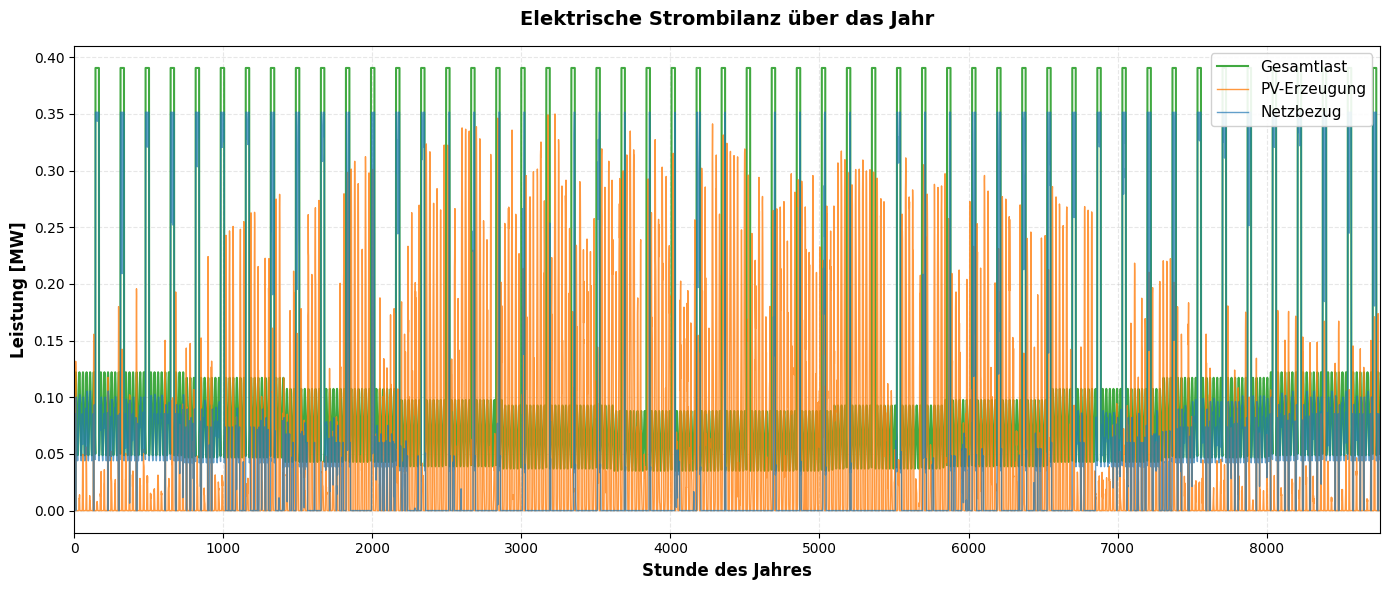

In [63]:
# Elektrische Strombilanz - Jahresübersicht
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Zeitliche Verläufe plotten
network.loads_t.p.sum(axis=1).plot(ax=ax, label="Gesamtlast", color='#2ca02c', linewidth=1.5, alpha=0.9)
network.generators_t.p["PV"].plot(ax=ax, label="PV-Erzeugung", color='#ff7f0e', linewidth=1, alpha=0.8)
network.generators_t.p["Grid"].plot(ax=ax, label="Netzbezug", color='#1f77b4', linewidth=1, alpha=0.7)

ax.set_ylabel("Leistung [MW]", fontsize=12, fontweight='bold')
ax.set_xlabel("Stunde des Jahres", fontsize=12, fontweight='bold')
ax.set_title("Elektrische Strombilanz über das Jahr", fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 8760])

plt.tight_layout()
plt.show()


In [ ]:
### 2️⃣ Jahresenergiemengen im Vergleich

**Was zeigt diese Grafik?**
Vergleicht die **Gesamtenergien** über das Jahr:
- **PV:** Gesamte erzeugte Solarenergie
- **Netz:** Eingekaufte Energie aus dem Stromnetz
- **Verbrauch:** Gesamter Stromverbrauch des Standorts

**Erkenntnisse:**
- Die PV-Anlage deckt einen signifikanten Teil des Bedarfs
- Die Differenz zwischen PV + Netz und Verbrauch zeigt die Systemeffizienz

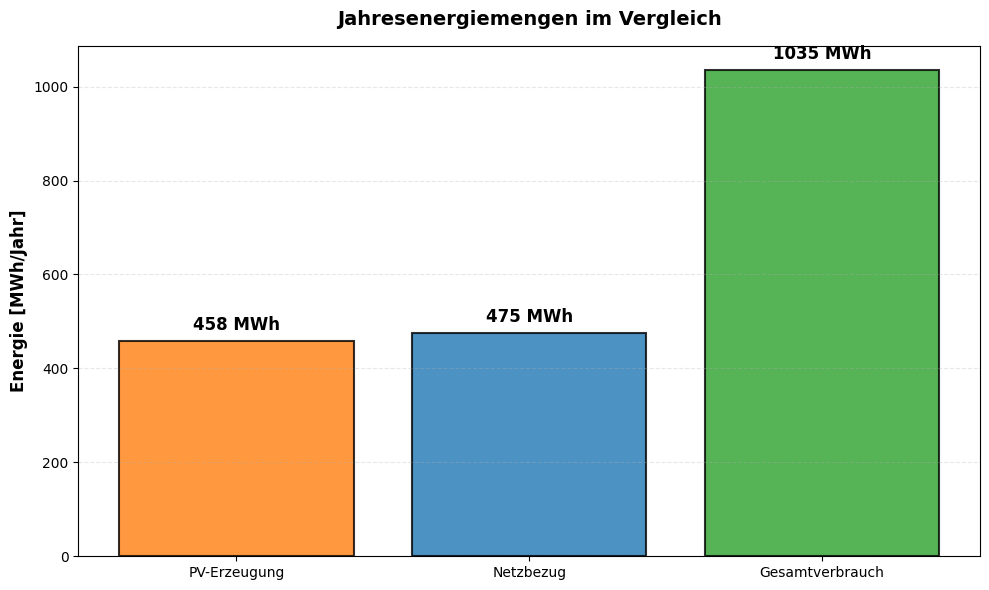

In [64]:
# Jahresenergiemengen im Vergleich
pv_energy = network.generators_t.p["PV"].sum()
grid_energy = network.generators_t.p["Grid"].clip(lower=0).sum()
total_load = network.loads_t.p.sum(axis=1).sum()

fig, ax = plt.subplots(figsize=(10, 6))

categories = ["PV-Erzeugung", "Netzbezug", "Gesamtverbrauch"]
energies = [pv_energy, grid_energy, total_load]
colors = ['#ff7f0e', '#1f77b4', '#2ca02c']

bars = ax.bar(categories, energies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Werte auf den Balken anzeigen
for bar, energy in zip(bars, energies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 15,
            f'{energy:.0f} MWh', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

ax.set_ylabel("Energie [MWh/Jahr]", fontsize=12, fontweight='bold')
ax.set_title("Jahresenergiemengen im Vergleich", fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


---

## 🔍 ZUSÄTZLICHE DETAILANALYSEN

Diese Grafiken bieten **vertiefte Einblicke** in spezifische Systemkomponenten und deren Betriebsverhalten.

### Netzbezugsleistung und Anschlussgrenze

**Was zeigt diese Grafik?**
- **Blaue Linie:** Tatsächlicher Leistungsbezug aus dem Stromnetz über das Jahr
- **Gestrichelte rote Linie:** Maximale Netzanschlussleistung (1,3 MW)

**Erkenntnisse:**
- Das System bleibt immer unter der Netzanschlussgrenze
- Peaks zeigen Zeiten hohen Strombedarfs (z.B. nächtliche Fahrzeugladung)
- Der Batteriespeicher hilft, Lastspitzen zu kappen

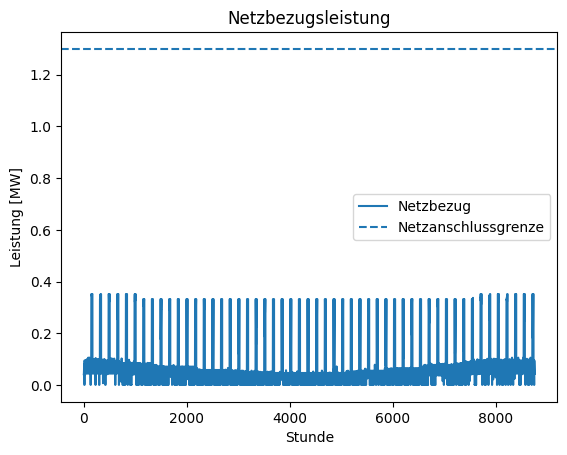

In [ ]:
# Netzbezugsleistung und Anschlussgrenze
fig, ax = plt.subplots(figsize=(14, 5))

network.generators_t.p["Grid"].plot(ax=ax, label="Netzbezug", color='#1f77b4', linewidth=1, alpha=0.8)

ax.axhline(y=network.generators.loc["Grid", "p_nom"], 
           linestyle="--", color='red', linewidth=2, 
           label=f"Netzanschlussgrenze ({network.generators.loc['Grid', 'p_nom']} MW)", alpha=0.9)

ax.set_ylabel("Leistung [MW]", fontsize=12, fontweight='bold')
ax.set_xlabel("Stunde des Jahres", fontsize=12, fontweight='bold')
ax.set_title("Netzbezugsleistung über das Jahr", fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 8760])

plt.tight_layout()
plt.show()

### Wärmepumpen-Betrieb (Heizung)

**Was zeigt diese Grafik?**
- **Orange:** Thermische Leistungsabgabe (erzeugte Wärme)
- **Blau:** Elektrische Leistungsaufnahme (benötigter Strom)

**Erkenntnisse:**
- Das Verhältnis thermisch/elektrisch zeigt die Effizienz (COP ≈ 3)
- Höchste Aktivität im Winter (erhöhter Heizbedarf)
- Die Wärmepumpe nutzt günstige Strompreise zur Wärmeerzeugung

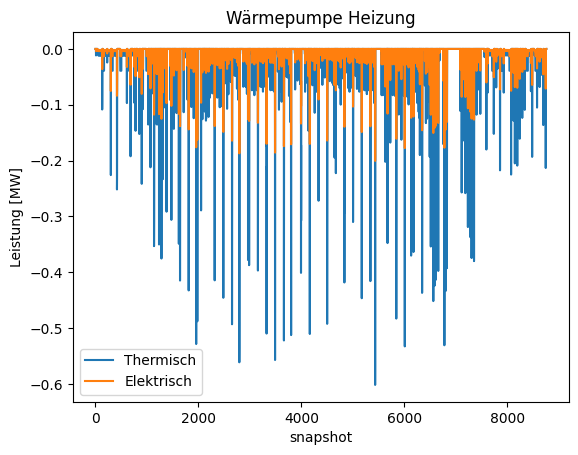

In [ ]:
# Wärmepumpen-Betrieb (Heizung)
fig, ax = plt.subplots(figsize=(14, 5))

# Thermische und elektrische Leistung
network.links_t.p1["Heat_Pump_1"].plot(ax=ax, label="Thermische Abgabe", 
                                        color='#ff7f0e', linewidth=1, alpha=0.8)
(-network.links_t.p0["Heat_Pump_1"]).plot(ax=ax, label="Elektrische Aufnahme", 
                                          color='#1f77b4', linewidth=1, alpha=0.8)

ax.set_ylabel("Leistung [MW]", fontsize=12, fontweight='bold')
ax.set_xlabel("Stunde des Jahres", fontsize=12, fontweight='bold')
ax.set_title("Wärmepumpe Heizung - Leistungsverläufe", fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 8760])

plt.tight_layout()
plt.show()


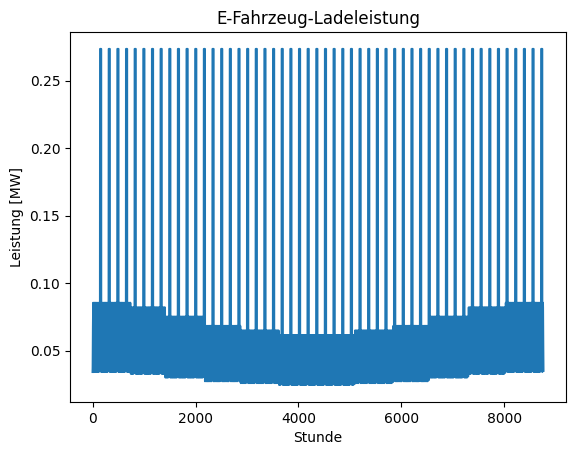

In [ ]:
# E-Fahrzeug-Ladeleistung
fig, ax = plt.subplots(figsize=(14, 5))

network.loads_t.p["Fleet_Load"].plot(ax=ax, color='#2ca02c', linewidth=1, alpha=0.8)

ax.set_ylabel("Leistung [MW]", fontsize=12, fontweight='bold')
ax.set_xlabel("Stunde des Jahres", fontsize=12, fontweight='bold')
ax.set_title("E-Fahrzeug-Flotte: Ladeleistung über das Jahr", fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 8760])

plt.tight_layout()
plt.show()


### E-Fahrzeug-Ladeleistung

**Was zeigt diese Grafik?**
- Stromverbrauch der E-Fahrzeugflotte über das Jahr

**Erkenntnisse:**
- Erkennbares Muster: Erhöhte Ladung in bestimmten Zeiträumen
- Die Flotte ist der größte Einzelverbraucher (70% des Lastprofils)
- Der Batteriespeicher hilft, die Ladung mit PV-Strom zu decken

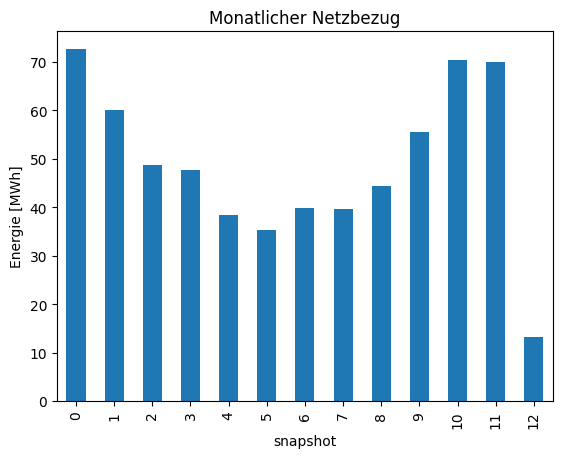

In [ ]:
# Monatlicher Netzbezug
monthly = network.generators_t.p["Grid"].groupby(
    network.snapshots // 720  # Gruppierung in "Monate" à 720 h
).sum()

fig, ax = plt.subplots(figsize=(12, 6))

bars = monthly.plot(kind="bar", ax=ax, color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel("Energie [MWh]", fontsize=12, fontweight='bold')
ax.set_xlabel("Monat (vereinfacht: 720h pro Monat)", fontsize=12, fontweight='bold')
ax.set_title("Monatlicher Netzbezug über das Jahr", fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_xticklabels([f"M{i+1}" for i in range(len(monthly))], rotation=0)

plt.tight_layout()
plt.show()


---

## 📝 Zusammenfassung der Grafiken-Struktur

### 🎯 **HAUPTERGEBNISSE** (Priorität 1 - Wichtigste Erkenntnisse)
1. **Vergleich mit/ohne Batteriespeicher** - Zeigt den Mehrwert des Batteriespeichers
   - Autarkiegrad: +15,6% Verbesserung
   - Kostenersparnis: 46.427 €/Jahr
   - Optimierte Speichergrößen für alle Komponenten

### 📈 **DETAILLIERTE ANALYSEN** (Priorität 2 - Systemverständnis)
2. **Elektrische Strombilanz** - Jahresübersicht der Energieflüsse
   - Zeigt Zusammenspiel von PV, Netz und Verbrauch
   - Erkennbar: Tag-Nacht-Muster der Energieversorgung

3. **Jahresenergiemengen** - Energiebilanz auf einen Blick
   - Vergleicht PV-Ertrag, Netzbezug und Gesamtverbrauch
   - Schneller Überblick über die Größenordnungen

### 🔍 **ZUSÄTZLICHE DETAILS** (Priorität 3 - Vertiefung)
4. **Netzbezugsleistung** - Prüfung der Netzanschlussgrenze
5. **Wärmepumpen-Betrieb** - Effizienz und Betriebsmuster
6. **E-Fahrzeug-Ladung** - Größter Einzelverbraucher
7. **Monatlicher Netzbezug** - Saisonale Schwankungen

**Empfehlung:** Konzentrieren Sie sich auf die Hauptergebnisse (1-3) für Präsentationen. Die zusätzlichen Details (4-7) eignen sich für technische Nachfragen und Detailanalysen.

### Monatlicher Netzbezug

**Was zeigt diese Grafik?**
- Netzbezug aufgeschlüsselt nach Monaten (vereinfacht: 720h pro "Monat")

**Erkenntnisse:**
- Höherer Netzbezug in Wintermonaten (weniger Sonne, mehr Heizbedarf)
- Niedriger Netzbezug in Sommermonaten (viel PV-Ertrag)
- Saisonale Schwankungen zeigen Optimierungspotenziale